# Medellin: Indicators for a Healthy City

Author: Cara Nolan

This notebook contains the data analysis of the Medellin Quality of Life Survey (2011 - 2017) and in doing so assesses the strengths and limitations of the survey to construct indicators that measure Medellin's progress as a healthy city.

**Disclaimer:** This notebook is a work in progress, containing the code for various data visualisations for a project analysing the health equity of Medellin, Colombia. It is not thoroughly commented or explained in as clean a state as I would like to share for others to use.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point
import scipy
import os
import geoplot
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import re
import seaborn as sns #; sns.set()

# Multidimensional Quality of Life Index

The city of Medellin conducts a quality of life survey of its citizens every year. From that survey, it constructs a multidimensional index across 15 dimensions to measure the city's quality of life.

In this analysis, we will examine the data aggregated by index. Specifically, we will explore:

1. Improvement: How has Medellin’s performance changed overall over time? On which indicators is it doing well; on which is it struggling? This will help us to understand both how Medellin is progressing in its journey towards being a healthy city, and which indicators are most descriptive of changes that the city is experiencing in the window of time from 2011 - 2017. This will assist us in refining the list of most pertinent indicators for measuring the city’s health.

2. Equity: 
* Spatial Equity: Which comunas perform better than the Medellin mean for given indicators, and which perform worse? How large is the gap between strong and weak performers? Is the gap widening or closing? 
* Gender Equity: Same questions as above, but related to gender equity.
* Socio-economic Equity: Same questions as above, but related to equity between the 6 ‘estratos’, or socio-economic levels, in Medellin. 
* Given equity is a core focus of what constitutes a healthy city, this analysis aims to give us a barometer of Medellin’s progress towards equity. 


Data:
* The summary of the indices can be found here:
http://medata.gov.co/medell%C3%ADn-en-cifras/indice-multidimensional-de-condiciones-de-vida-imcv-2011-2017

* The raw data to download can be found here: http://medata.gov.co/dataset/%C3%ADndice-multidimensional-encuesta-calidad-de-vida

In [2]:
# read in data
index = pd.read_csv("./encuesta-calidad-de-vida-2011-2017/indice_multidimensional_encuesta_calidad_de_vida.csv", sep=";")
index.head()

,multidimensional_vida.varcharidcomunafk,multidimensional_vida.intaño,multidimensional_vida.decentornocalidadvivienda,multidimensional_vida.decaccesoserviciospublicos,multidimensional_vida.decmedioambiente,multidimensional_vida.decescolaridad,multidimensional_vida.decdescolarizacion,multidimensional_vida.decmovilidad,multidimensional_vida.deccapitalfisicohogar,multidimensional_vida.decparticipacion,multidimensional_vida.declibertadseguridad,multidimensional_vida.decvulnerabilida,multidimensional_vida.decsalud,multidimensional_vida.dectrabajo,multidimensional_vida.decrecreacion,multidimensional_vida.decpercepcioncalidadvida,multidimensional_vida.decingresos,multidimensional_vida.decimcv
0,1,2011,1.380000,3.570000,2.510000,1.470000,3.880000,1.370000,3.310000,1.100000,1.840000,6.350000,2.550000,0.510000,0.190000,1.2500,0.780000,32.06
1,1,2012,1.390000,3.610000,2.280000,1.590000,3.900000,1.350000,3.680000,0.810000,1.590000,6.900000,2.620000,0.520000,0.330000,1.4000,0.960000,32.88
2,1,2013,1.390000,3.570000,2.250000,1.580000,3.910000,1.400000,3.830000,0.960000,1.850000,6.690000,2.650000,0.570000,0.050000,1.3600,1.100000,33.27
3,1,2014,1.411854,3.589982,2.121174,1.603315,3.975634,1.295639,3.739863,1.000021,1.599736,6.952948,2.569105,0.552032,0.058456,1.2784,1.121182,32.82
4,1,2015,1.237000,3.607000,1.753000,1.811000,4.146000,1.262000,3.667000,1.098000,1.729000,7.018000,3.041000,0.485000,0.067000,1.3550,1.039000,33.53


In [3]:
# rename columns
index.rename(columns={'multidimensional_vida.varcharidcomunafk': "Comuna", 
                      "multidimensional_vida.intaño": "Year",
                       'multidimensional_vida.decentornocalidadvivienda': "Environment_and_Housing_Quality",
                       'multidimensional_vida.decaccesoserviciospublicos': "Access_to_Public_Services",
                       'multidimensional_vida.decmedioambiente': "Environment",
                       'multidimensional_vida.decescolaridad':"Schooling_escoloridad",
                       'multidimensional_vida.decdescolarizacion':"Education_escolarizacion",
                       'multidimensional_vida.decmovilidad':"Mobility",
                       'multidimensional_vida.deccapitalfisicohogar':"Physical_Capital_of_the_Home",
                       'multidimensional_vida.decparticipacion':"Civic_Participation",
                       'multidimensional_vida.declibertadseguridad':"Freedom_and_Security",
                       'multidimensional_vida.decvulnerabilida':"Vulnerability",
                       'multidimensional_vida.decsalud':"Healthcare", 
                       'multidimensional_vida.dectrabajo':"Employment",
                       'multidimensional_vida.decrecreacion':"Recreation",
                       'multidimensional_vida.decpercepcioncalidadvida':"Perception_of_Quality_of_Life",
                       'multidimensional_vida.decingresos':"Income", 
                       'multidimensional_vida.decimcv':"Overall_Score"
                      }, inplace = True)

index.columns

Index(['Comuna', 'Year', 'Environment_and_Housing_Quality',
       'Access_to_Public_Services', 'Environment', 'Schooling_escoloridad',
       'Education_escolarizacion', 'Mobility', 'Physical_Capital_of_the_Home',
       'Civic_Participation', 'Freedom_and_Security', 'Vulnerability',
       'Healthcare', 'Employment', 'Recreation',
       'Perception_of_Quality_of_Life', 'Income', 'Overall_Score'],
      dtype='object')

In [4]:
# Delete comunas greater than comuna 16 (i.e. those outside the city center) - not considered the heart of Medellin, plus there's a bunch of missing data for them
index = index.query("Comuna <= 16")
index.head()

,Comuna,Year,Environment_and_Housing_Quality,Access_to_Public_Services,Environment,Schooling_escoloridad,Education_escolarizacion,Mobility,Physical_Capital_of_the_Home,Civic_Participation,Freedom_and_Security,Vulnerability,Healthcare,Employment,Recreation,Perception_of_Quality_of_Life,Income,Overall_Score
0,1,2011,1.380000,3.570000,2.510000,1.470000,3.880000,1.370000,3.310000,1.100000,1.840000,6.350000,2.550000,0.510000,0.190000,1.2500,0.780000,32.06
1,1,2012,1.390000,3.610000,2.280000,1.590000,3.900000,1.350000,3.680000,0.810000,1.590000,6.900000,2.620000,0.520000,0.330000,1.4000,0.960000,32.88
2,1,2013,1.390000,3.570000,2.250000,1.580000,3.910000,1.400000,3.830000,0.960000,1.850000,6.690000,2.650000,0.570000,0.050000,1.3600,1.100000,33.27
3,1,2014,1.411854,3.589982,2.121174,1.603315,3.975634,1.295639,3.739863,1.000021,1.599736,6.952948,2.569105,0.552032,0.058456,1.2784,1.121182,32.82
4,1,2015,1.237000,3.607000,1.753000,1.811000,4.146000,1.262000,3.667000,1.098000,1.729000,7.018000,3.041000,0.485000,0.067000,1.3550,1.039000,33.53


In [7]:
index.describe().to_csv("Input Data Summary - Medellin Quality of Life.csv")
index.to_csv("Input Data - Medellin Quality of Life.csv")

### 1. Improvement: How has Medellin's performance changed over time?
#### a. graph over time

In [8]:
# Theoretical Maximum for Each Value - derived from the website
# 'Comuna': 1
# 'Year': 1
# 'Environment_and_Housing_Quality': 9.76
# 'Access_to_Public_Services': 4.49
# 'Environment': 7.03
# 'Schooling_escoloridad': 8.79
# 'Education_escolarizacion': 4.66
# 'Mobility': 3.09
# 'Physical_Capital_of_the_Home': 16.86
# 'Civic_Participation': 2.33
# 'Freedom_and_Security': 3.43
# 'Vulnerability': 22.18
# 'Healthcare': 6.69
# 'Employment': 2.27
# 'Recreation': 1.73
# 'Perception_of_Quality_of_Life': 2.4
# 'Income': 4.24
# 'Overall_Score': 1
    
theoretical_max = [1,1,9.76,4.49,7.03,8.79,4.66,3.09,16.86,2.33,3.43,22.18,6.69,2.27,1.73,2.4,4.24,100] #from website

In [9]:
# Normalize each indicator using the theoretical maximum (from the website) so that each value ranges from 0 to 1
index_normalized = index / theoretical_max
# index_normalized.head()
# index_normalized.describe()

In [10]:
# Create data for graphing: group by year and calculate the mean
summary_normalized = index_normalized.groupby('Year').mean()
summary_normalized = summary_normalized.reset_index()
summary_normalized["Year"] = summary_normalized["Year"].astype(int)
summary_normalized

,Year,Comuna,Environment_and_Housing_Quality,Access_to_Public_Services,Environment,Schooling_escoloridad,Education_escolarizacion,Mobility,Physical_Capital_of_the_Home,Civic_Participation,Freedom_and_Security,Vulnerability,Healthcare,Employment,Recreation,Perception_of_Quality_of_Life,Income,Overall_Score
0,2011,8.5,0.454598,0.892121,0.429854,0.270762,0.885864,0.510720,0.386788,0.482296,0.487063,0.530771,0.518311,0.265969,0.225434,0.627344,0.391952,0.482669
1,2012,8.5,0.454662,0.895184,0.404427,0.285481,0.893911,0.496764,0.386418,0.480150,0.465926,0.554131,0.491125,0.261013,0.197977,0.628906,0.407871,0.485306
2,2013,8.5,0.454278,0.896993,0.396515,0.286476,0.894850,0.497168,0.396575,0.543723,0.516946,0.536097,0.505792,0.292952,0.034682,0.620573,0.425118,0.484850
3,2014,8.5,0.454993,0.897320,0.400991,0.284883,0.903160,0.487365,0.397953,0.562186,0.501092,0.554254,0.507339,0.279768,0.039246,0.622044,0.443853,0.489988
4,2015,8.5,0.448668,0.877366,0.354027,0.290828,0.912446,0.483697,0.369736,0.563090,0.535295,0.559454,0.537341,0.265171,0.043353,0.634974,0.385333,0.483644
5,2016,8.5,0.461416,0.893135,0.385501,0.287004,0.908218,0.494569,0.399490,0.567776,0.531237,0.550516,0.514676,0.287212,0.034554,0.641409,0.457530,0.492212
6,2017,8.5,0.458921,0.871482,0.374616,0.286908,0.914770,0.475522,0.385953,0.545741,0.496413,0.561340,0.497974,0.238895,0.048226,0.636658,0.441064,0.486456
7,2018,8.5,0.459444,0.882052,0.390161,0.291947,0.916212,0.500028,0.395468,0.598676,0.495667,0.558545,0.523884,0.240788,0.055939,0.650223,0.481262,0.495456


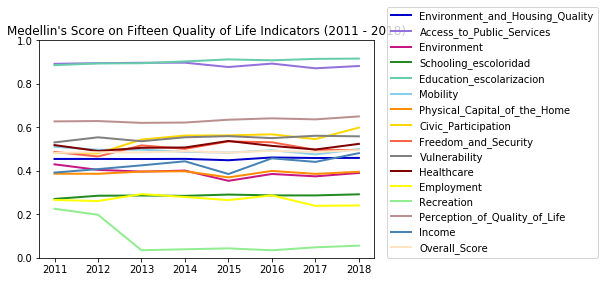

In [11]:
#Change over time for Medellin on all 15 indicators, grouped into 4 categories:

#Plot 1:  All Variables
x = summary_normalized["Year"].values
counter = 0
var_list = (['Environment_and_Housing_Quality',
       'Access_to_Public_Services', 'Environment', 'Schooling_escoloridad',
       'Education_escolarizacion', 'Mobility', 'Physical_Capital_of_the_Home',
       'Civic_Participation', 'Freedom_and_Security', 'Vulnerability',
       'Healthcare', 'Employment', 'Recreation',
       'Perception_of_Quality_of_Life', 'Income', 'Overall_Score'])

for i in var_list:
#     colors = ["green","green", "blue", "red", "black", "orange"]
    colors = ["mediumblue", "mediumblue", "mediumpurple", "mediumvioletred", "forestgreen","mediumaquamarine", "skyblue", "darkorange", "gold", "tomato", "gray", "maroon", "yellow", "lightgreen", "rosybrown", "steelblue", "bisque"]
    y = summary_normalized[i].values
    counter += 1
    plt.plot(x,y, color=colors[counter], linestyle='solid', linewidth=2, label = i)
plt.ylim(0, 1)
plt.title("Medellin's Score on Fifteen Quality of Life Indicators (2011 - 2018)")
plt.legend(loc=(1.04,0))
plt.savefig("Summary_Overall_All_Indicators.png", bbox_inches='tight')
plt.show();


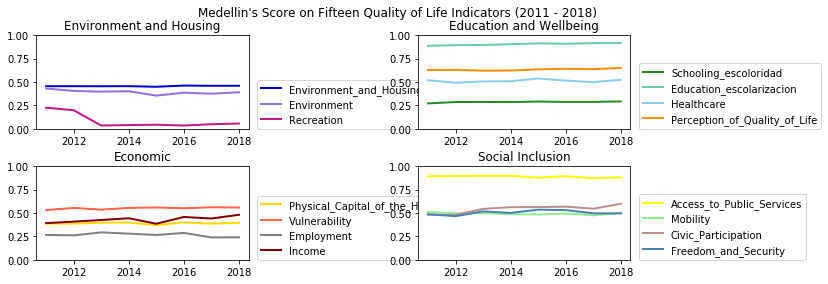

In [12]:
# Plot 2: Variables broken down by group
x = summary_normalized["Year"].values
counter = 0
a = "Environment and Housing"
var_list_a = (['Environment_and_Housing_Quality',
       'Environment', 'Recreation'])

b = "Education and Wellbeing"
var_list_b = (['Schooling_escoloridad','Education_escolarizacion',
       'Healthcare', 'Perception_of_Quality_of_Life',])

c = "Economic"
var_list_c = (['Physical_Capital_of_the_Home', 'Vulnerability','Employment', 'Income'])

d = "Social Inclusion"
var_list_d = (['Access_to_Public_Services',  'Mobility', 'Civic_Participation', 
               'Freedom_and_Security'])


plt.subplots_adjust(right=1.5, wspace = 0.8, bottom = 0.1, hspace = 0.4)
plt.subplot(221)
for i in var_list_a:
#     colors = ["green","green", "blue", "red", "black", "orange"]
    colors = ["mediumblue", "mediumblue", "mediumpurple", "mediumvioletred", "forestgreen","mediumaquamarine", "skyblue", "darkorange", "gold", "tomato", "gray", "maroon", "yellow", "lightgreen", "rosybrown", "steelblue", "bisque"]
    y = summary_normalized[i].values
    counter += 1
    plt.plot(x,y, color=colors[counter], linestyle='solid', linewidth=2, label = i)
plt.ylim(0, 1)
plt.title(a)
plt.legend(loc=(1.04,0))

plt.subplot(222)
for i in var_list_b:
#     colors = ["green","green", "blue", "red", "black", "orange"]
    colors = ["mediumblue", "mediumblue", "mediumpurple", "mediumvioletred", "forestgreen","mediumaquamarine", "skyblue", "darkorange", "gold", "tomato", "gray", "maroon", "yellow", "lightgreen", "rosybrown", "steelblue", "bisque"]
    y = summary_normalized[i].values
    counter += 1
    plt.plot(x,y, color=colors[counter], linestyle='solid', linewidth=2, label = i)
plt.ylim(0, 1)
plt.title(b)
plt.legend(loc=(1.04,0))

plt.subplot(223)
for i in var_list_c:
#     colors = ["green","green", "blue", "red", "black", "orange"]
    colors = ["mediumblue", "mediumblue", "mediumpurple", "mediumvioletred", "forestgreen","mediumaquamarine", "skyblue", "darkorange", "gold", "tomato", "gray", "maroon", "yellow", "lightgreen", "rosybrown", "steelblue", "bisque"]
    y = summary_normalized[i].values
    counter += 1
    plt.plot(x,y, color=colors[counter], linestyle='solid', linewidth=2, label = i)
plt.ylim(0, 1)
plt.title(c)
plt.legend(loc=(1.04,0))

plt.subplot(224)
for i in var_list_d:
#     colors = ["green","green", "blue", "red", "black", "orange"]
    colors = ["mediumblue", "mediumblue", "mediumpurple", "mediumvioletred", "forestgreen","mediumaquamarine", "skyblue", "darkorange", "gold", "tomato", "gray", "maroon", "yellow", "lightgreen", "rosybrown", "steelblue", "bisque"]
    y = summary_normalized[i].values
    counter += 1
    plt.plot(x,y, color=colors[counter], linestyle='solid', linewidth=2, label = i)
plt.ylim(0, 1)
plt.title(d)
plt.legend(loc=(1.04,0))

# plt.legend(loc=(1.04,0))
plt.suptitle("Medellin's Score on Fifteen Quality of Life Indicators (2011 - 2018)", horizontalalignment = "left")
plt.savefig("Summary_Overall_All_Indicators_separately.png", bbox_inches='tight')
plt.show();



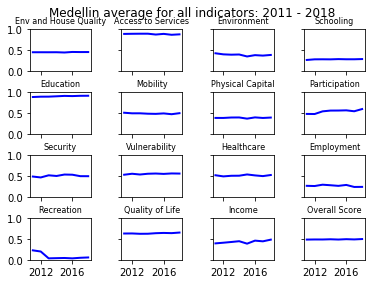

In [15]:
#Plot C: Each graph on its own:

x = summary_normalized["Year"].values
varlist = summary_normalized.columns[2:]
nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
varnames = (['Env and House Quality', 'Access to Services',
       'Environment', 'Schooling', 'Education',
       'Mobility', 'Physical Capital', 'Participation',
       'Security', 'Vulnerability', 'Healthcare', 'Employment',
       'Recreation', 'Quality of Life', 'Income',
       'Overall Score'])

fig, axs = plt.subplots(4,4, sharex=True, sharey = True)
fig.figsize=(300,300)
fig.suptitle('Medellin average for all indicators: 2011 - 2018', horizontalalignment = 'center')
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.5)
# plt.xticks(np.arange(2), ('2011', '2018'), fontsize=8)
for axi in axs.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(2))
    
for i in range(0,16):
    y = summary_normalized[varlist[i]].values
    axs[nrows[i],ncols[i]].plot(x, y, color='blue', linestyle='solid', linewidth=2)
    axs[nrows[i],ncols[i]].set_ylim([0, 1])
#     axs[nrows[i],ncols[i]].axis('off')
#     axs[nrows[i],ncols[i]].xticks([], [])
    axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)

plt.savefig("FINAL - Summary_Overall_All_Indicators.png", dpi = 300)
plt.show();


#Use this to pull the legend
# data.plot(column = varlist[1], cmap = 'Blues', vmin = 0, vmax = 2, legend = True)
# plt.savefig("Legend_to_steal_deviation_2018.png", dpi = 300)
# plt.show();

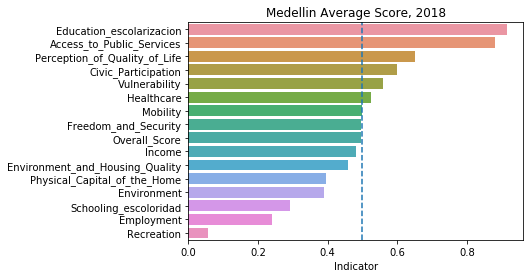

In [16]:
# Mean Performance, at 2018

a = summary_normalized.query("Year == 2018").iloc[:,2:]
a = a.transpose() 
a.rename(columns = {7: "Indicator"}, inplace = True)
a = a.sort_values("Indicator", ascending = False)
a

sns.barplot(x = a["Indicator"], y = a.index.values)
plt.title("Medellin Average Score, 2018")
plt.axvline(0.5, linestyle = "dashed")
plt.savefig("FINAL - average score all indicators.png", bbox_inches='tight')
plt.show();



#### c. Percent change over time
Calculate (and graph) the percent change in the mean score over time (2011 - 2017) for each variable, and then for each comuna on the overall score, and then for each comuna on all variables...

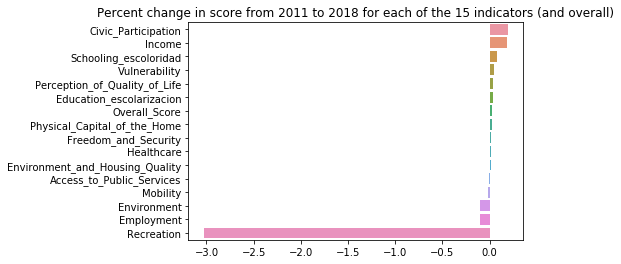

In [17]:
index_2018 = index_normalized.query("Year == 2018")
index_2011 = index_normalized.query("Year == 2011")
perc_change = (np.mean(index_2018) - np.mean(index_2011)) / np.mean(index_2018)
perc_change = perc_change[2:] # drop year and comuna because meaningless
perc_change = perc_change.sort_values(ascending = False) 

sns.barplot(y = perc_change.index, x = perc_change)
plt.title("Percent change in score from 2011 to 2018 for each of the 15 indicators (and overall)")
plt.savefig("Percent_Change_Overall.png", bbox_inches='tight')
plt.show();


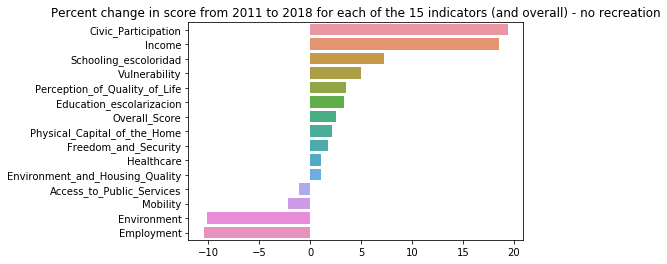

In [18]:
#without recreation
index_2018_no_rec = index_normalized.query("Year == 2018").drop(columns=["Recreation"])
index_2011_no_rec = index_normalized.query("Year == 2011").drop(columns=["Recreation"])
perc_change_no_rec = (np.mean(index_2018_no_rec) - np.mean(index_2011_no_rec)) / np.mean(index_2018_no_rec) * 100
perc_change_no_rec = perc_change_no_rec[2:] # drop year and comuna because meaningless
perc_change_no_rec = perc_change_no_rec.sort_values(ascending = False) 

sns.barplot(y = perc_change_no_rec.index, x = perc_change_no_rec)
plt.title("Percent change in score from 2011 to 2018 for each of the 15 indicators (and overall) - no recreation")
plt.savefig("FINAL - Percent_Change_no_Recreation.png", bbox_inches='tight')
plt.show();

#Next steps: change the colors, make the graph a little more elegant, perhaps group by size (so those with most progress at top, those with least at bottom)

In [19]:
index_2018_no_rec = index_normalized.query("Year == 2018")#.drop(columns=["Recreation"])
index_2011_no_rec = index_normalized.query("Year == 2011")#.drop(columns=["Recreation"])
perc_change_no_rec = (np.mean(index_2018_no_rec) - np.mean(index_2011_no_rec)) / np.mean(index_2018_no_rec) * 100
perc_change_no_rec = perc_change_no_rec[2:] # drop year and comuna because meaningless
perc_change_no_rec = perc_change_no_rec.sort_values(ascending = False) 
perc_change_no_rec

Civic_Participation                 19.439510
Income                              18.557569
Schooling_escoloridad                7.256233
Vulnerability                        4.972489
Perception_of_Quality_of_Life        3.518739
Education_escolarizacion             3.312387
Overall_Score                        2.580954
Physical_Capital_of_the_Home         2.194730
Freedom_and_Security                 1.735992
Healthcare                           1.063813
Environment_and_Housing_Quality      1.054889
Access_to_Public_Services           -1.141567
Mobility                            -2.138257
Environment                        -10.173427
Employment                         -10.457929
Recreation                        -302.997672
dtype: float64

### 2: Spatial Equity
#### a. Percent Change For Each Comuna

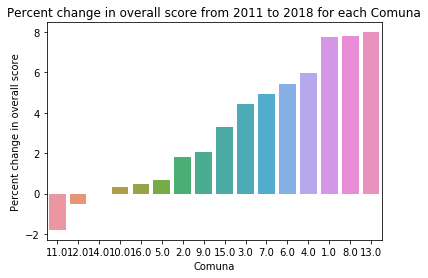

In [20]:
# Percent change on 'Overall score' for each comuna
overall_2018 = index_normalized.query("Year == 2018").loc[:,["Comuna","Overall_Score"]]
overall_2018.rename(columns={"Overall_Score": "score_2018"}, inplace = True)
overall_2011 = index_normalized.query("Year == 2011").loc[:,["Comuna","Overall_Score"]]
overall_2011.rename(columns={"Overall_Score": "score_2011"}, inplace = True)
overall_score = pd.merge(overall_2018, overall_2011, how='inner', on='Comuna')
overall_score["perc_change"] = (overall_score["score_2018"] - overall_score["score_2011"])/overall_score["score_2018"]*100
overall_score = overall_score.sort_values("perc_change", ascending = True)

sns.barplot(y =overall_score["perc_change"], x = overall_score["Comuna"], order=overall_score["Comuna"])
plt.title("Percent change in overall score from 2011 to 2018 for each Comuna")
plt.xlabel("Comuna")
plt.ylabel("Percent change in overall score")
plt.savefig("Percent_Change_Overall_by_Comuna.png", bbox_inches='tight')
plt.show();

#what happened to comuna 14? check accuracy of the numbers?

#### b.  Equity Analysis - deviation from the mean

In [29]:
#  Calculate percent change in deviation from Medellin mean for each indicator
dev_2011 = index_normalized.query("Year == 2011").iloc[:, 2:] #iloc to remove comuna and year cols
dev_2011 = dev_2011/np.mean(dev_2011)
dev_2011['Comuna'] = list(range(1,len(dev_2011) + 1))
dev_2011 = dev_2011.set_index('Comuna')

dev_2018 = index_normalized.query("Year == 2018").iloc[:, 2:]
dev_2018 = dev_2018/np.mean(dev_2018)
dev_2018['Comuna'] = list(range(1,len(dev_2018) + 1))
dev_2018 = dev_2018.set_index('Comuna')

dev = dev_2018.sub(dev_2011, axis = 'columns')
dev = dev.div(dev_2011, axis = 'columns')
dev = dev * 100 #so it's in %
dev["category"] = ['2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score above mean', '2011 score above mean', '2011 score above mean', '2011 score above mean', '2011 score below mean', '2011 score above mean', '2011 score above mean', '2011 score above mean'] 


dev_2018_shifted = dev_2018 - 1 #so that it centers on 0 not 1
dev_2018_shifted 


dev_2011_shifted = dev_2011 - 1 #so that it centers on 0 not 1
dev_2011_shifted["category"] = ['2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score below mean', '2011 score above mean', '2011 score above mean', '2011 score above mean', '2011 score above mean', '2011 score below mean', '2011 score above mean', '2011 score above mean', '2011 score above mean'] 
dev_2011_shifted


,Environment_and_Housing_Quality,Access_to_Public_Services,Environment,Schooling_escoloridad,Education_escolarizacion,Mobility,Physical_Capital_of_the_Home,Civic_Participation,Freedom_and_Security,Vulnerability,Healthcare,Employment,Recreation,Perception_of_Quality_of_Life,Income,Overall_Score,category
Comuna,,,,,,,,,,,,,,,,,
1,2.356985,0.370683,-1.322915,9.361813,0.596986,1.770785,16.400558,-17.715101,-7.129967,4.100404,18.428138,17.701777,43.250931,10.152978,44.285419,5.593008,2011 score below mean
2,4.156713,-5.008043,-8.623150,10.529729,0.634364,-11.056407,4.032779,5.664256,-11.234833,2.648106,-2.210135,11.487981,-69.652819,-3.843512,19.518456,-0.761038,2011 score below mean
3,-3.964433,-1.852874,-3.307942,4.694659,1.259291,-10.200410,4.149803,-3.728894,1.099970,8.712395,2.204231,2.822447,22.239027,-2.479962,17.914122,1.965994,2011 score below mean
4,1.968797,0.806576,4.105373,2.566052,1.161416,0.900795,2.590656,6.102480,7.036318,5.344451,2.147280,-5.711141,36.737805,2.826053,9.116735,3.619293,2011 score below mean
5,-1.683393,-0.757734,-10.170104,-1.419159,1.007503,-3.836222,0.205095,1.858890,9.857341,-2.054511,-8.653024,13.435551,-13.536018,-3.624116,8.275849,-1.907410,2011 score below mean
6,-0.686225,-0.672760,1.111392,2.338908,0.627117,7.341388,2.648629,7.044037,25.478655,4.402414,1.907625,-6.737514,8.626398,0.360588,9.596256,3.026261,2011 score below mean
7,5.160414,0.020686,1.784175,5.085634,-1.176923,0.413869,1.181150,3.993774,-4.466081,4.659853,1.154864,-0.460188,5.030658,6.290192,-0.430681,2.485547,2011 score below mean
8,2.925009,5.487375,0.300574,3.300427,2.042548,4.773189,10.111410,-0.715299,3.863644,7.502793,6.202302,2.913304,7.100227,2.707706,19.693301,5.677154,2011 score below mean
9,1.148786,1.202868,-5.647653,-0.316567,0.265717,-4.542725,1.950381,1.936645,-1.949083,0.531797,-2.565708,-3.081668,-43.038574,1.435815,3.039204,-0.548485,2011 score above mean


In [24]:
dev_2018['Overall_Score']

Comuna
1     0.701374
2     0.748401
3     0.755869
4     0.890492
5     0.970015
6     0.823282
7     0.930859
8     0.800676
9     1.007354
10    1.138748
11    1.405169
12    1.250161
13    0.815814
14    1.546050
15    1.056602
16    1.159134
Name: Overall_Score, dtype: float64

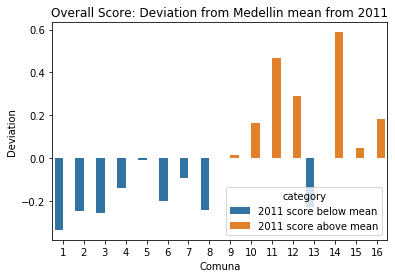

In [30]:
#One graph - overall score - deviation for each comuna

sns.barplot(y = dev_2011_shifted["Overall_Score"].values, x = dev_2011_shifted .index.values, hue = dev_2011_shifted["category"])#, order = dev_2018["Overall_Score"].sort_values(ascending = False).index.values)
plt.title("Overall Score: Deviation from Medellin mean from 2011")
plt.xlabel("Comuna")
plt.ylabel("Deviation")
plt.savefig("FINAL Deviation:" + "Overall_Score" + ".png", bbox_inches='tight')
plt.show();

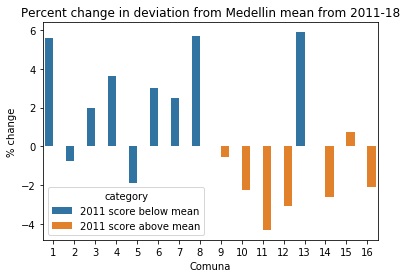

In [31]:
#One graph - overall score - deviation for each comuna
sns.barplot(y = dev["Overall_Score"].values, x = dev.index.values, hue = dev["category"])#, order = dev["Overall_Score"].sort_values(ascending = False).index.values)
plt.title("Percent change in deviation from Medellin mean from 2011-18")
plt.xlabel("Comuna")
plt.ylabel("% change")
plt.savefig("FINAL Deviation perc_change:" + "Overall_Score" + ".png", bbox_inches='tight')
plt.show();

#### c.  Spatial Mapping of Equity

##### Import shapefile and match comuna to comunas in Medellin

In [31]:
comunas = gpd.read_file('./Limite_Comuna_Corregimiento/Limite_Comuna_Corregimiento.shp')

# remove the two rows that aren't comunas
comunas = comunas[comunas['CODIGO'] != 'SN02']
comunas = comunas[comunas['CODIGO'] != 'SN01']

# rename CODIGO to be COMUNA and make numeric
comunas['Comuna'] = pd.to_numeric(comunas['CODIGO'], errors='coerce', downcast=None)

# remove the Corregimiento (village) to get just to a list of comunas
comunas = comunas[comunas['Comuna'] <= 16]

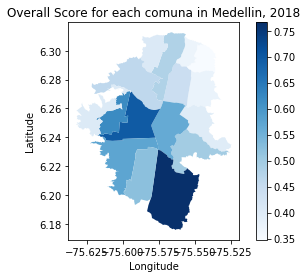

In [32]:
# calc overall score 2018
score_2018 = index_normalized.query("Year == 2018").loc[:,['Comuna', 'Overall_Score']]
score_2018 

# add it as a column to COMUNAS dataframe
spatial_score = pd.merge(comunas, score_2018, how = 'left', on = 'Comuna')
spatial_score

# AND NOW PLOT ON MAP:
# Plot percent voted by comuna (all years)
spatial_score.plot(column = 'Overall_Score', legend = True, cmap = 'Blues')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Overall Score for each comuna in Medellin, 2018")
plt.show();


In [ ]:
#Creating GIFs

# Interestingly,the scores don't really change at all over time... is that accurate?
spatial_scores = index_normalized.loc[:,['Comuna', 'Year', 'Overall_Score']]
spatial_scores = pd.merge(comunas, spatial_scores, how = 'left', on = 'Comuna')
spatial_scores


output_path = './maps'

for year in spatial_scores["Year"].unique():
    score = spatial_scores.loc[spatial_scores['Year'] == year,:]
    score.plot(column = 'Overall_Score', legend = True, cmap = 'Blues', vmin = 0, vmax = 1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Overall Score for each comuna in Medellin: " + str(int(year)))
    filepath = os.path.join(output_path, 'map'+str(int(year))+'.jpg')
    plt.savefig(filepath, dpi=300)
    
# Command line entries to use imagemagick to stick all of the jpgs together into one gif:
# cd /Users/caranolan/Documents/3\ -\ Fall\ 2019\ Semester\ 3/Healthy\ Cities/Option\ D:\ Medellín/Data/maps
# convert -delay 10 -loop 0 map* my_map.gif

# embed the gif in the notebook
from IPython.display import HTML
HTML('<img src="./maps/my_map.gif">')

In [ ]:
from IPython.display import HTML
HTML('<img src="./maps/my_map.gif">')

##### All fifteen indicators mapped

###### i) 2018 scores

In [ ]:
summary_normalized.describe()

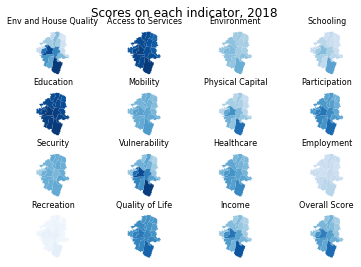

In [34]:
# A. 2018 scores
data = index_normalized.query("Year == 2018")
data = pd.merge(comunas, data, how = 'left', on = 'Comuna')
varlist = index_normalized.columns[2:]
nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
varnames = (['Env and House Quality', 'Access to Services',
       'Environment', 'Schooling', 'Education',
       'Mobility', 'Physical Capital', 'Participation',
       'Security', 'Vulnerability', 'Healthcare', 'Employment',
       'Recreation', 'Quality of Life', 'Income',
       'Overall Score'])

fig, axs = plt.subplots(4,4)
fig.figsize=(300,300)
fig.suptitle('Scores on each indicator, 2018', horizontalalignment = 'center')
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.3)

# fig.subplots_adjust(right=0.5, wspace = 0.5, bottom = 0.5, hspace = 0.4)

for i in range(0,16):
    data.plot(ax = axs[nrows[i],ncols[i]],column = varlist[i], cmap = 'Blues', vmax = 1, vmin = 0) 
    axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)
    axs[nrows[i],ncols[i]].axis('off')
plt.savefig("Grid_scores.png", dpi = 300)
plt.show();

# to do: manually add legend from cell below

In [36]:
data.to_csv("shapefile + 2018 comuna mean for each comuna.csv")

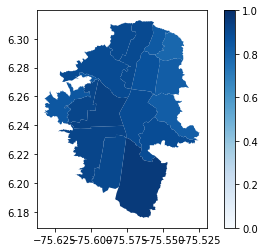

In [176]:
#Use this to pull the legend
data.plot(column = varlist[1], cmap = 'Blues', vmax = 1, vmin = 0, legend = True)
plt.savefig("Legend_to_steal.png", dpi = 300)

###### ii) % change from 2011 - 2018, by comuna

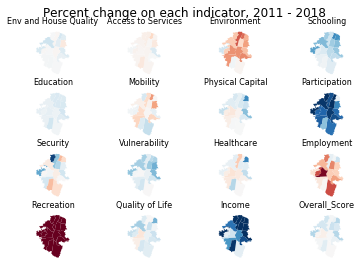

In [229]:
# Calculate percent change for each indicator and comuna
index_2018 = index_normalized.query("Year == 2018")
index_2018 = index_2018.set_index('Comuna')
index_2011 = index_normalized.query("Year == 2011")
index_2011 = index_2011.set_index('Comuna')

perc_change = index_2018.sub(index_2011, axis = 'columns')
perc_change = perc_change / index_2011 *100
perc_change = perc_change.iloc[:,1:] #remove year column
perc_change = perc_change.reset_index()
perc_change

#Create maps of each indicator:
data = perc_change
data = pd.merge(comunas, data, how = 'left', on = 'Comuna')
varlist = index_normalized.columns[2:]
nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
varnames = (['Env and House Quality', 'Access to Services',
       'Environment', 'Schooling', 'Education',
       'Mobility', 'Physical Capital', 'Participation',
       'Security', 'Vulnerability', 'Healthcare', 'Employment',
       'Recreation', 'Quality of Life', 'Income',
       'Overall Score'])

fig, axs = plt.subplots(4,4)
fig.figsize=(300,300)
fig.suptitle('Percent change on each indicator, 2011 - 2018', horizontalalignment = 'center')
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.3)

# fig.subplots_adjust(right=0.5, wspace = 0.5, bottom = 0.5, hspace = 0.4)

for i in range(0,16):
    data.plot(ax = axs[nrows[i],ncols[i]],column = varlist[i], cmap = 'RdBu', vmin = -30, vmax = 30) 
    axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)
    axs[nrows[i],ncols[i]].axis('off')
plt.savefig("Grid_perc_change.png", dpi = 300)
plt.show();

# Steal Legend from Below

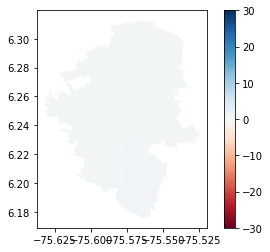

In [232]:
#Use this to pull the legend
# data.plot(column = varlist[1], cmap = 'Blues', vmax = 1, vmin = 0, legend = True)
data.plot(column = varlist[1], cmap = 'RdBu', vmin = -30, vmax = 30, legend = True)
plt.savefig("Legend_to_steal_redblue.png", dpi = 300)
plt.show();

###### iii) deviation from the mean

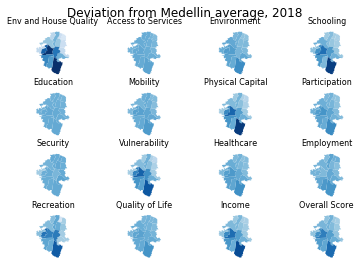

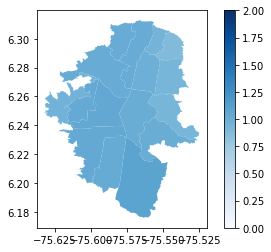

In [239]:
#  Calculate deviation and percent change in deviation from Medellin mean for each indicator
dev_2011 = index_normalized.query("Year == 2011").iloc[:, 2:] #iloc to remove comuna and year cols
dev_2011 = dev_2011/np.mean(dev_2011)
dev_2011['Comuna'] = list(range(1,len(dev_2011) + 1))
dev_2011 = dev_2011.set_index('Comuna')

dev_2018 = index_normalized.query("Year == 2018").iloc[:, 2:]
dev_2018 = dev_2018/np.mean(dev_2018)
dev_2018['Comuna'] = list(range(1,len(dev_2018) + 1))
dev_2018 = dev_2018.set_index('Comuna')

dev = dev_2018.sub(dev_2011, axis = 'columns')
dev = dev.div(dev_2011, axis = 'columns')
dev = dev * 100 #so it's in %

dev_2018 # deviation from Medellin mean, 2018
dev # percent change in deviation from Medellin, 2011-2018


#Create maps of each indicator - DEVIATION:
data = dev_2018
data = pd.merge(comunas, data, how = 'left', on = 'Comuna')
varlist = index_normalized.columns[2:]
nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
varnames = (['Env and House Quality', 'Access to Services',
       'Environment', 'Schooling', 'Education',
       'Mobility', 'Physical Capital', 'Participation',
       'Security', 'Vulnerability', 'Healthcare', 'Employment',
       'Recreation', 'Quality of Life', 'Income',
       'Overall Score'])

fig, axs = plt.subplots(4,4)
fig.figsize=(300,300)
fig.suptitle('Deviation from Medellin average, 2018', horizontalalignment = 'center')
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.3)

for i in range(0,16):
    data.plot(ax = axs[nrows[i],ncols[i]],column = varlist[i], cmap = 'Blues', vmin = 0, vmax = 2) 
    axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)
    axs[nrows[i],ncols[i]].axis('off')
plt.savefig("Grid_Deviation_2018.png", dpi = 300)
plt.show();

#Use this to pull the legend
data.plot(column = varlist[1], cmap = 'Blues', vmin = 0, vmax = 2, legend = True)
plt.savefig("Legend_to_steal_deviation_2018.png", dpi = 300)
plt.show();

###### iii) percent change in the deviation from the mean

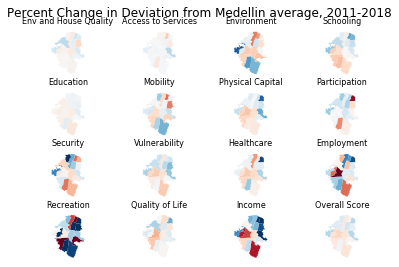

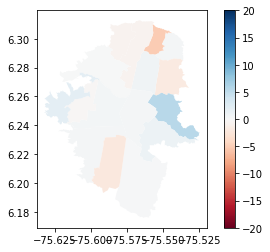

In [244]:
data = dev
data = pd.merge(comunas, data, how = 'left', on = 'Comuna')
varlist = index_normalized.columns[2:]
nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
varnames = (['Env and House Quality', 'Access to Services',
       'Environment', 'Schooling', 'Education',
       'Mobility', 'Physical Capital', 'Participation',
       'Security', 'Vulnerability', 'Healthcare', 'Employment',
       'Recreation', 'Quality of Life', 'Income',
       'Overall Score'])

fig, axs = plt.subplots(4,4)
fig.figsize=(300,300)
fig.suptitle('Percent Change in Deviation from Medellin average, 2011-2018', horizontalalignment = 'center')
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.3)

for i in range(0,16):
    data.plot(ax = axs[nrows[i],ncols[i]],column = varlist[i], cmap = 'RdBu', vmin = -20, vmax = 20) 
    axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)
    axs[nrows[i],ncols[i]].axis('off')
plt.savefig("Grid_Deviation_Change_2011-18.png", dpi = 300)
plt.show();

#Use this to pull the legend
data.plot(column = varlist[1], cmap = 'RdBu', vmin = -20, vmax = 20, legend = True)
plt.savefig("Legend_to_steal_deviation_change.png", dpi = 300)
plt.show();

###### iii) score GIF 2011 - 2018

In [249]:
index_normalized["Year"].unique()

array([2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.])

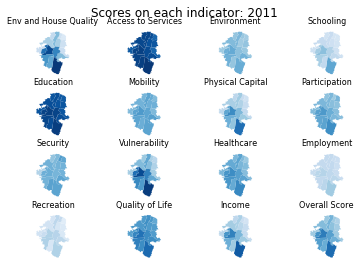

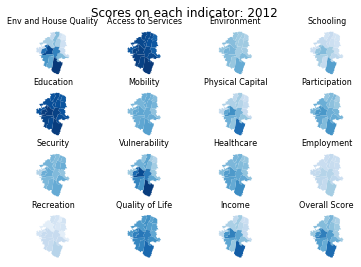

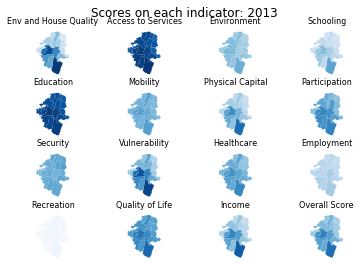

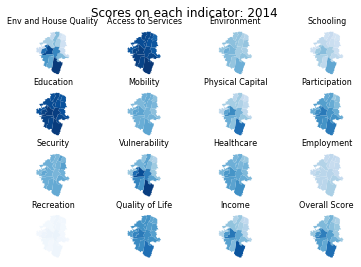

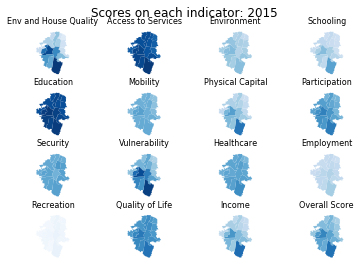

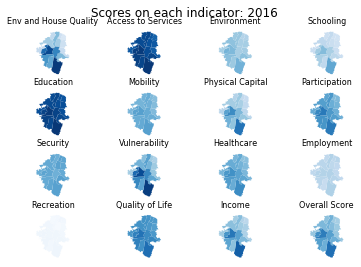

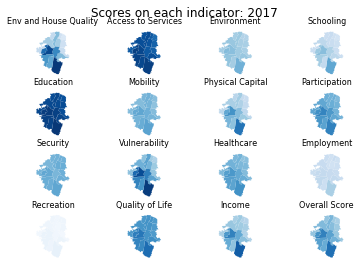

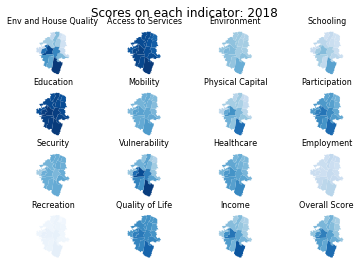

In [253]:
# os.mkdir('./maps_all_scores')
output_path = './maps_all_scores'
for year in index_normalized["Year"].unique():

    data = index_normalized.loc[index_normalized['Year'] == year,:]
    data = pd.merge(comunas, data, how = 'left', on = 'Comuna')
    varlist = index_normalized.columns[2:]
    nrows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
    ncols = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
    varnames = (['Env and House Quality', 'Access to Services',
           'Environment', 'Schooling', 'Education',
           'Mobility', 'Physical Capital', 'Participation',
           'Security', 'Vulnerability', 'Healthcare', 'Employment',
           'Recreation', 'Quality of Life', 'Income',
           'Overall Score'])

    fig, axs = plt.subplots(4,4)
    fig.figsize=(300,300)
    fig.suptitle('Scores on each indicator: ' + str(int(year)), horizontalalignment = 'center')
    fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.3)

    for i in range(0,16):
        data.plot(ax = axs[nrows[i],ncols[i]],column = varlist[i], cmap = 'Blues', vmax = 1, vmin = 0) 
        axs[nrows[i],ncols[i]].set_title(varnames[i], fontsize=8)
        axs[nrows[i],ncols[i]].axis('off')
    filepath = os.path.join(output_path, 'map'+str(int(year))+'.jpg')
    plt.savefig(filepath, dpi = 300)
    plt.show();

    


In [254]:
# Command line entries to use imagemagick to stick all of the jpgs together into one gif:
# cd /Users/caranolan/Documents/3\ -\ Fall\ 2019\ Semester\ 3/Healthy\ Cities/Option\ D:\ Medellín/Data/maps_all_scores
# convert -delay 60 -loop 0 map* my_map_all_scores.gif

# embed the gif in the notebook
from IPython.display import HTML
HTML('<img src="./maps_all_scores/my_map_all_scores.gif">')


## Estratos mapped

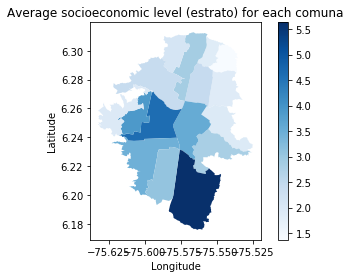

In [377]:
# Average Estrato for each Comuna
# https://medellinguru.com/colombia-estratos/
estratos = pd.DataFrame({'Comuna': np.arange(1,17), 'estrato': [1.37,1.87,1.89,2.44,2.87,2.11,2.41,1.94,2.82,3.56,4.62,3.89,1.96,5.63,3.08,3.46]})
estratos

estratos = pd.merge(comunas, estratos, how = 'left', on = 'Comuna')

# AND NOW PLOT ON MAP:
estratos.plot(column = 'estrato', legend = True, cmap = 'Blues')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Average socioeconomic level (estrato) for each comuna")
plt.savefig("FINAL - estratos.png", dpi = 300)
plt.show();